In [ ]:
!pip install -q -U accelerate
!pip install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 22.7 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("google-research-datasets/go_emotions", "raw")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

In [ ]:
data = dataset

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
})

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertPreTrainedModel, BertModel, TrainingArguments, Trainer
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터셋을 pandas 데이터프레임으로 변환
df = data['train'].to_pandas()

# 제거할 컬럼 이름 리스트
drop_cols = ['disapproval', 'embarrassment', 'approval', 'confusion', 'realization', 'pride',
            'curiosity', 'desire', 'relief', 'gratitude', 'fear', 'nervousness', 'neutral']

# 제거할 컬럼들의 값이 1인 행 인덱스 구하기
drop_idx = df[df[drop_cols].sum(axis=1) > 0].index

# 해당 행 제거
df = df.drop(drop_idx)

# 컬럼 제거
df = df.drop(drop_cols, axis=1)

In [ ]:
# 학습에 불필요한 컬럼 제거
columns_to_drop = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']
df = df.drop(columns=columns_to_drop)

In [ ]:
# 5가지 감정 기준 맞추기
df['happy'] = df[['admiration', 'amusement', 'joy', 'optimism']].max(axis=1)
df['romantic'] = df[['love', 'caring']].max(axis=1)
df['sad'] = df[['disappointment', 'grief', 'sadness', 'remorse']].max(axis=1)
df['aggressive'] = df[['anger', 'annoyance', 'disgust']].max(axis=1)
df['dramatic'] = df[['excitement', 'surprise']].max(axis=1)


# 기존 컬럼 제거
df = df.drop(columns=['anger', 'annoyance', 'disgust',
                     'disappointment', 'grief', 'sadness', 'remorse',
                      'admiration', 'amusement', 'excitement', 'caring',
                        'surprise', 'joy', 'love', 'optimism'])

In [ ]:
check_col = ['happy', 'romantic', 'sad', 'aggressive', 'dramatic']

# 특정 열의 값이 전부 0인 행 제거
df = df.loc[(df[check_col] != 0).any(axis=1)]

In [ ]:
df.columns

Index(['text', 'happy', 'romantic', 'sad', 'aggressive', 'dramatic'], dtype='object')

In [ ]:
# 레이블 정의
labels = ['happy', 'romantic', 'sad', 'aggressive', 'dramatic']

In [ ]:
df

,text,happy,romantic,sad,aggressive,dramatic
0,That game hurt.,0,0,1,0,0
3,Man I love reddit.,0,1,0,0,0
7,That's crazy; I went to a super [RELIGION] hig...,1,0,0,0,0
8,that's adorable asf,1,0,0,0,0
9,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",1,0,0,0,0
...,...,...,...,...,...,...
211219,"Well, I'm glad you're out of all that now. How...",1,0,0,0,0
211220,Everyone likes [NAME].,0,1,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,1,0,0,0
211222,That looks amazing,1,0,0,0,0


In [ ]:
df[labels].value_counts()

happy  romantic  sad  aggressive  dramatic
1      0         0    0           0           27163
0      0         0    1           0           18220
                 1    0           0           11310
       1         0    0           0            8681
       0         0    0           1            6612
1      1         0    0           0            1714
       0         0    0           1            1538
0      0         1    1           0            1176
1      0         1    0           0             782
                 0    1           0             706
0      1         1    0           0             322
                 0    1           0             293
                      0           1             244
       0         0    1           1             193
                 1    0           1             170
1      1         0    0           1             109
                 1    0           0              38
       0         1    1           0              37
       1         0   

In [ ]:
# labels = ['happy', 'romantic', 'sad', 'aggressive', 'dramatic']

# # 레이블을 문자열로 변환하여 새로운 컬럼 추가
# df['combined_labels'] = df[labels].apply(lambda row: ''.join(row.astype(str)), axis=1)

In [ ]:
# df['combined_labels'].value_counts()

In [ ]:
df[labels].sum(axis=0)

happy         32134
romantic      11444
sad           13874
aggressive    20674
dramatic       8904
dtype: int64

In [ ]:
label_cols = ['happy', 'romantic', 'sad', 'aggressive', 'dramatic']

# 레이블 조합별 데이터 개수 계산
label_counts = df[label_cols].sum(axis=0).to_frame('counts')
total_count = df.shape[0]
label_percentages = (label_counts / total_count)

label_percentages

,counts
happy,0.404817
romantic,0.144169
sad,0.174782
aggressive,0.260447
dramatic,0.112171


In [ ]:
# labels = ['disgust', 'fear', 'neutral', 'angry', 'sad', 'happy']

# # 레이블을 문자열로 변환하여 새로운 컬럼 추가
# df['combined_labels'] = df[labels].apply(lambda row: ''.join(row.astype(str)), axis=1)

In [ ]:
# # 전체 데이터의 0.1%만 사용하여 테스트
# subset_fraction = 0.001  # 0.1%

# # 0.1% 데이터를 랜덤하게 샘플링
# df_subset, _ = train_test_split(df, train_size=subset_fraction, random_state=42)

# # 훈련 및 검증 데이터 분리 (0.1% 데이터셋을 이용하여 다시 분리)
# train_df, valid_df = train_test_split(df_subset, test_size=0.2, random_state=42)

# # 데이터셋 크기 확인
# print(f"Train size: {len(train_df)}, Valid size: {len(valid_df)}")

In [ ]:
# 훈련 및 검증 데이터 분리
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# BERT 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 데이터 토큰화 및 인코딩
def encode_data(texts):
    # texts를 리스트로 변환
    texts_list = texts.tolist()
    return tokenizer(texts_list, padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = encode_data(train_df['text'])
valid_encodings = encode_data(valid_df['text'])

# 레이블 텐서로 변환
train_labels = torch.tensor(train_df[labels].values, dtype=torch.float32)
valid_labels = torch.tensor(valid_df[labels].values, dtype=torch.float32)

# 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
valid_dataset = TensorDataset(valid_encodings['input_ids'], valid_encodings['attention_mask'], valid_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [ ]:
# BERT 모델 초기화
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 옵티마이저 및 손실 함수
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# 학습 함수
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    for batch in tqdm(dataloader, desc="Training"):
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs.logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels.float())
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs.logits) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='micro')
    return avg_loss, accuracy, f1

# 학습 및 평가
num_epochs = 5
best_acc = 0
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid F1: {valid_f1:.4f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        os.makedirs('output', exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), 'output/6moods_best_model.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 44.54it/s]


Train Loss: 0.6020, Train Acc: 0.0849, Valid Loss: 0.5915, Valid Acc: 0.0370, Valid F1: 0.0588
Epoch 2/5


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 45.67it/s]


Train Loss: 0.5626, Train Acc: 0.0472, Valid Loss: 0.5646, Valid Acc: 0.0000, Valid F1: 0.0000
Epoch 3/5


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 44.10it/s]


Train Loss: 0.5273, Train Acc: 0.0472, Valid Loss: 0.5349, Valid Acc: 0.0000, Valid F1: 0.0000
Epoch 4/5


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 45.16it/s]


Train Loss: 0.5010, Train Acc: 0.0283, Valid Loss: 0.5039, Valid Acc: 0.0000, Valid F1: 0.0000
Epoch 5/5


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 43.77it/s]

Train Loss: 0.4670, Train Acc: 0.0472, Valid Loss: 0.4796, Valid Acc: 0.0000, Valid F1: 0.0000


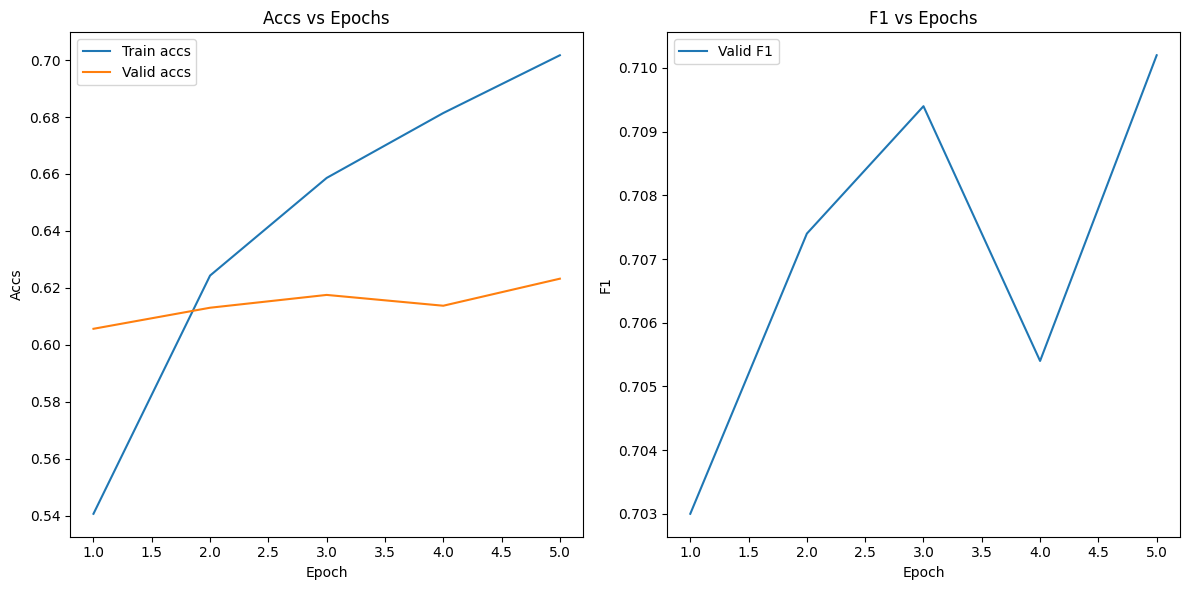

In [ ]:
epochs = range(1, 6)

# Acc 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train accs')
plt.plot(epochs, valid_acc, label='Valid accs')
plt.xlabel('Epoch')
plt.ylabel('Accs')
plt.title('Accs vs Epochs')
plt.legend()

# F1 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, valid_f1, label='Valid F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1 vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()